In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import PatchCollection, LineCollection
from matplotlib.patches import Ellipse
import json
import pandas as pd
import matplotlib.patches as mpatches
from shapely.geometry import Polygon
from matplotlib import pyplot
from shapely.geometry.point import Point
import shapely.affinity
from shapely.geometry import LineString
from descartes import PolygonPatch
from shapely.figures import SIZE, GREEN, GRAY, set_limits
from shapely.ops import cascaded_union
from shapely.geometry import CAP_STYLE, JOIN_STYLE
import matplotlib.colors as clrs
import matplotlib.cm as cmx
import matplotlib.collections as mcoll
import matplotlib.path as mpath
from scipy.interpolate import CubicSpline
import seaborn as sns
from sklearn.cluster import KMeans, MeanShift,estimate_bandwidth
from shapely.ops import cascaded_union, polygonize
from scipy.spatial import Delaunay
import math
import shapely.geometry as geometry
from os import walk
from matplotlib import colors, patches

In [2]:
C_map=[(1,1,0.75),                  #  0
        (0.50588,0.99608,0.78824), #   1     
        (1,0.80196,0.2),#              2
        (1,0.4, 0),                #     3
        (1,0.4, 0),         #             4
        (0.75294, 0.75294, 0.75294), #    5
        (0.50196, 0.50196, 0.50196),  #   6   
        (0, 0.50196, 0),              #   7
        (0, 0.84314, 0),              #   8    
        (0, 0, 0.71765),              #   9
        (0.486, 0.388, 0.898),        #  10
        (0.8, 0.85, 0.99216),         #   11 
        (0.3, 0.7, 1),                #   12
        (0.25, 0.25, 1),              #   13
        (0.522, 0.263, 0.969),        #   14 %        0.5 0.2 0.2;...         14
        (0.8, 0.6, 0),                #   15
        (1, 0.8, 0.8),                #   16
        (0.99, 0.4, 0.4),             #   17        
        (0.6705882, 0.9, 0.5),        #   18
        (1, 1, 1),                    #       19 -               
        (0.6, 0.6, 0.6),              #   	20 -
        (0, 0, 0),                    #       21 -
        (0, 0, 0),                    #       22 -
        (1, 1, 0.31765),              #   23
        (1, 0.90196, 0.18824),        #   24
        (0.6, 0.6, 0.2),               #  25
        (0.4, 0.4, 0),                  # 26
        (0.9, 0.012, 0.78),            #  27
        (1, 0.43922, 0.99608),         #  28
        (1, 1, 1),                     #      29 -
        (1, 0, 0),                     #  30
        (1, 0, 0),                     #      31 -
        (0.55, 0, 0.8),                #  32
        (0, 0, 0),                     #     33 -
        (0.831, 0.69, 0.98),            #  34
        (0.988, 0.776, 0.357),    #     	35 -
        (0, 0.298, 0.267),          #     36
        (0, 0.298, 0.659),           #    37
        (0, 0.812, 0.453)]          #   38

In [3]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
data = pd.io.json.json_normalize(json.loads(open('./res_dir/data.json').read())["data"])
experiments = pd.io.json.json_normalize(json.loads(open('./res_dir/experiments.json').read())["data"])

In [5]:
def create_collections(_data):
    poly_coll = []
    col_coll = []
    cent_coll = []
    for poly, color in zip(_data.points,_data.color):
        poly_coll.append(plt.Polygon(poly))
        col_coll.append(list(map(lambda s: int(s.replace(" ", "")) / 256, color.split(','))))
        cent_coll.append(list(Polygon(poly).centroid.coords)[0])
    return (poly_coll, col_coll, cent_coll)

In [6]:
def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:,order]

In [7]:
def colorline(
    x, y, z=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0),
        linewidth=3, alpha=1.0):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha)

    ax = plt.gca()
    ax.add_collection(lc)

    return lc

In [8]:
def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

In [9]:
def create_ellipsis(exp_temp, exp_pres):
    ells = []
    for x,y in zip(exp_temp, exp_pres):
        nstd = 2
        y = list(map(lambda i: i/10,y))
        cov = np.cov(x, y)
        vals, vecs = eigsorted(cov)
        theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
        w, h = 2 * nstd * np.sqrt(vals)
        ells.append((np.mean(x), np.mean(y), w/2,h/2,theta,x,y))
    return ells

In [10]:
def create_focus_area(ells):    
    shp_ells = []
    for ell in ells:
        # 1st elem = center point (x,y) coordinates
        # 2nd elem = the two semi-axis values (along x, along y)
        # 3rd elem = angle in degrees between x-axis of the Cartesian base
        #            and the corresponding semi-axis
        ellipse = ((ell[0], ell[1]),(ell[2], ell[3]),ell[4])
        # Let create a circle of radius 1 around center point:
        circ = shapely.geometry.Point(ellipse[0]).buffer(1)

        # Let create the ellipse along x and y:
        ell  = shapely.affinity.scale(circ, (ellipse[1][0]), (ellipse[1][1]))

        # Let rotate the ellipse (clockwise, x axis pointing right):
        ellr = shapely.affinity.rotate(ell,ellipse[2])
        
        shp_ells.append(ellr)
    union = cascaded_union(shp_ells)
    union = union.simplify(0.2, preserve_topology=True).buffer(0.05)
    return union

In [11]:
ells = create_ellipsis(experiments.temp, experiments.pres)
focus_area = create_focus_area(ells)

In [12]:
def plot_polygons(config):
    ells = []
    legend = []
    colls = []
    
    polygons = config['polygons']
    colors = config['colors']
    centers = config['centers']
    names = config['names']
    exp_temp = config['exp_temp']
    exp_pres = config['exp_pres']
    exp_color = config['exp_color']
    exp_zone = config['exp_zone']
    res_lines = config['res_lines']
    res_time = config['res_time']
    union = config['focus_area']
    
    fig, ax = plt.subplots(figsize=(20, 10))
    coll = PatchCollection(polygons, facecolor=colors,alpha=0.4,edgecolors=colors,linewidth=4)
    # Make the collection and add it to the plot.
    ax.add_collection(coll)
    for center, name in zip(centers, names): 
        ax.annotate(name,center, horizontalalignment='center',verticalalignment='center')
    ax.set_ylim([0,1.6])
    ax.set_xlim([100,1000])

    for e,c in zip(create_ellipsis(exp_temp, exp_pres), exp_color):
        ell = Ellipse(xy=(np.mean(e[0]), np.mean(e[1])),
                   width=e[2]*2, height=e[3]*2,
                   angle=e[4], color=c, alpha=0.4)
        ell.set_facecolor(c)
        ax.add_artist(ell)
        plt.scatter(e[5],e[6],color=c)
    
    for c,z in zip(exp_color, exp_zone):
        legend.append(mpatches.Patch(color=c, label=f'zone {z}'))
    
    for line,t in zip(res_lines, res_time):
        _x, _y = line.xy
        z_max = round(max(t)/50,3)
        z = np.linspace(0, z_max, len(_x))
        colorline(_x, _y, z[::], cmap=plt.get_cmap('hot'), linewidth=4)

    xs, ys = union.exterior.xy
    # Make the collection and add it to the plot.
    ax.fill(xs, ys, alpha=0.6, fc='w', ec='none')    
    ax.legend(handles=legend)
    dummy_cl = plt.scatter(np.zeros(len(res_time[0])),np.zeros(len(res_time[0])),c=res_time[0], cmap='hot')
    plt.colorbar(label='Ma', ticks=np.linspace(0,50,11))
    ax.set_ylabel('Pressure, GPa')
    ax.set_xlabel('Temperature, celcus')

In [13]:
def find_lines(group, focus_area):
    t = group['temp']
    p = list(map(lambda pa: round(pa/10**9,2),group['pa']))
    l = LineString(zip(t.values,p))
    return l.crosses(focus_area)

In [14]:
def create_lines(group):
    t = group['temp']
    p = list(map(lambda pa: round(pa/10**9,2),group['pa']))
    return LineString(zip(t.values,p))

In [15]:
def create_time(group):
    t = group['ma']
    return list(map(lambda i: i/10**6, t.values))

In [16]:
def calc_area(line):
    try:
        x,y = line.xy
        return Polygon(zip(x,y)).area
    except:
        return 0

In [17]:
model_name = 'nres_160_0_1_v5_5_6.tsv'

In [ ]:
time, draw_data = read_voacc('../160/')
res = list(map(parse_voacc,draw_data))

In [18]:
df = pd.read_csv(f'./res_dir/{model_name}',sep='\t', names = ["id","x", "y", "pa", "temp","ma"], usecols=range(0,6))

In [19]:
crosses = df.groupby('id').filter(find_lines, focus_area = focus_area)
lines = crosses.groupby('id').apply(create_lines)
time = crosses.groupby('id').apply(create_time)
areas = lines.apply(calc_area)
lengths = lines.apply(lambda line: line.length)

In [20]:
X = list(zip(areas.values, lengths.values))
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)
cls = MeanShift(bandwidth=bandwidth, bin_seeding=True) 
cls.fit(X)

MeanShift(bandwidth=110.00295399920873, bin_seeding=True, cluster_all=True,
     min_bin_freq=1, n_jobs=1, seeds=None)

Text(0.5,1,'nres_160_0_1_v5_5_6.tsv')

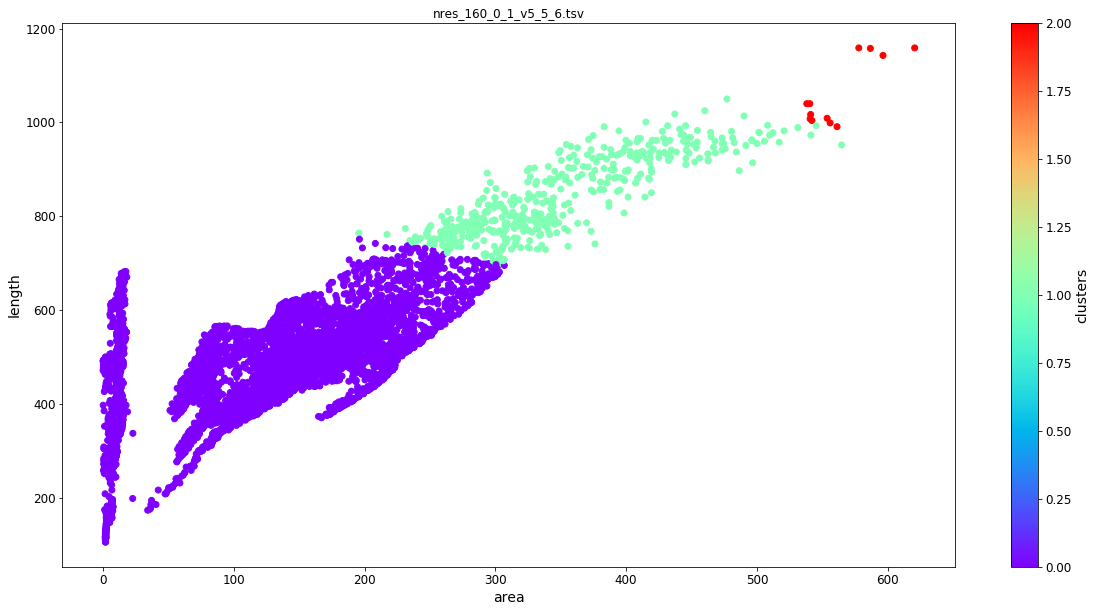

In [21]:
plt.figure(figsize=(20,10))
plt.scatter(areas, lengths, c=cls.labels_,cmap='rainbow')
plt.colorbar(label='clusters')
ax = plt.gca()
ax.set_ylabel('length')
ax.set_xlabel('area')
ax.set_title(f'{model_name}')

In [22]:
df2=lines.to_frame()
df2['cluster'] = cls.labels_
df2['time'] = time.values
df2 = df2.rename(index=str, columns={0:"lines"})

In [23]:
def filter_by_cluster(id):
    if type(id) == type([]):
        dl = df2[df2['cluster'].isin(id)]['lines'].values
        dt = df2[df2['cluster'].isin(id)]['time'].values
    else:
        dl = df2[df2['cluster'] == id]['lines'].values
        dt = df2[df2['cluster'] == id]['time'].values
    return (dl,dt)

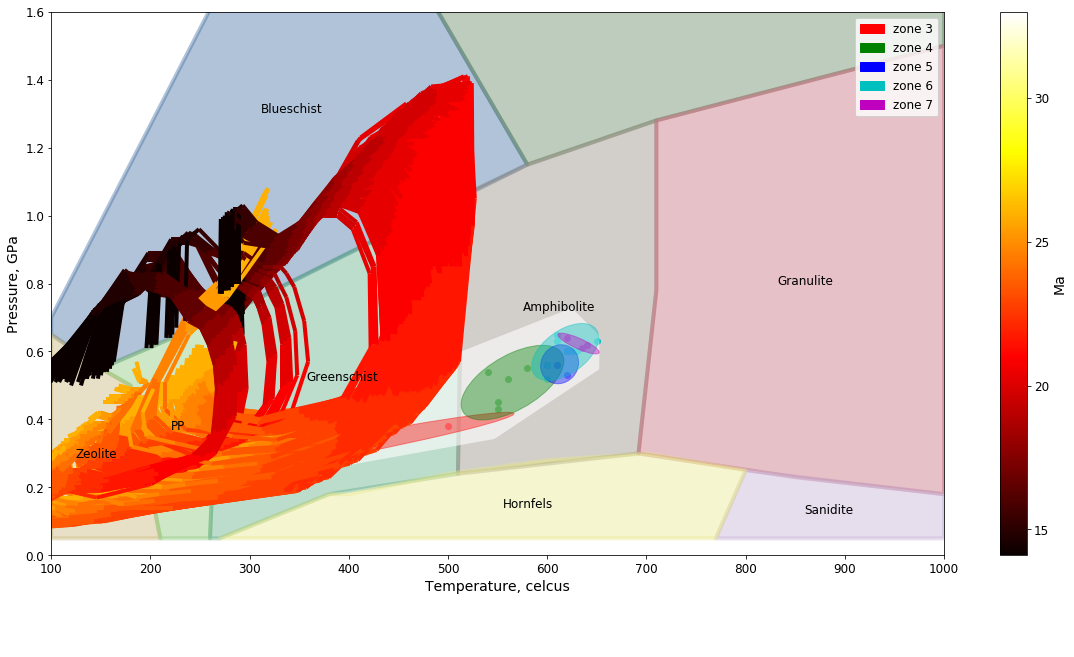

In [24]:
pol, col,cents = create_collections(data)
_dl,_dt = filter_by_cluster(0)
config = {
    'polygons': pol,
    'colors'  : col,
    'centers' : cents,
    'names'   : data.name,
    'exp_temp': experiments.temp,
    'exp_pres': experiments.pres,
    'exp_color':experiments.color,
    'exp_zone': experiments.zone,
    'res_lines': _dl[:400],
    'res_time' : _dt[:400],
    'focus_area'    : focus_area
}

plot_polygons(config)

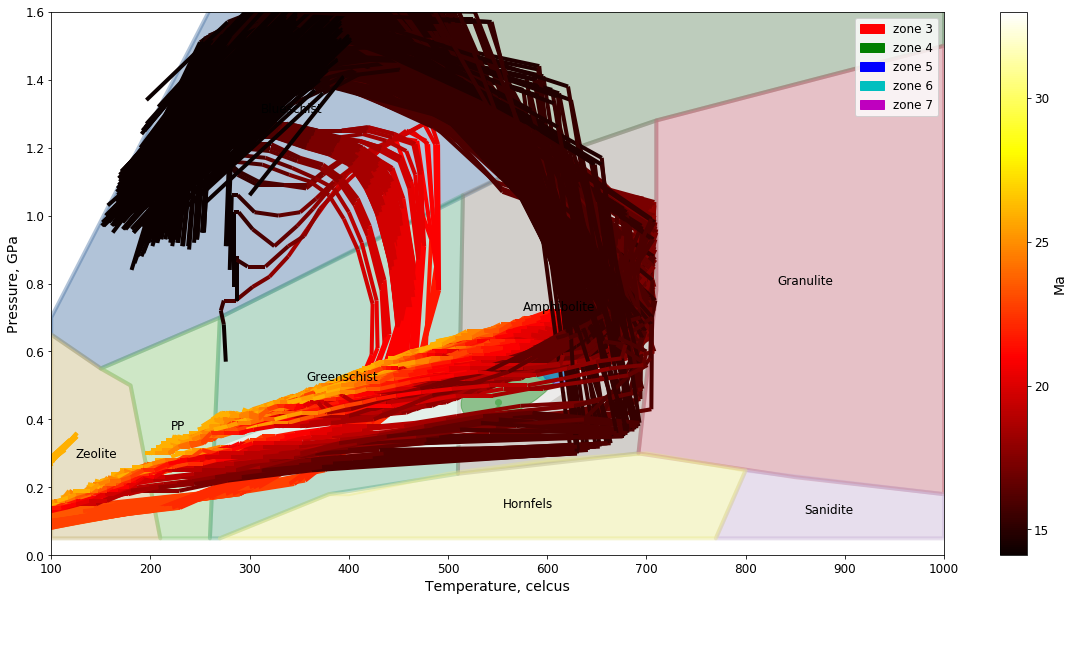

In [25]:
pol, col,cents = create_collections(data)
_dl,_dt = filter_by_cluster(1)
config = {
    'polygons': pol,
    'colors'  : col,
    'centers' : cents,
    'names'   : data.name,
    'exp_temp': experiments.temp,
    'exp_pres': experiments.pres,
    'exp_color':experiments.color,
    'exp_zone': experiments.zone,
    'res_lines': _dl[:400],
    'res_time' : _dt[:400],
    'focus_area'    : focus_area
}

plot_polygons(config)

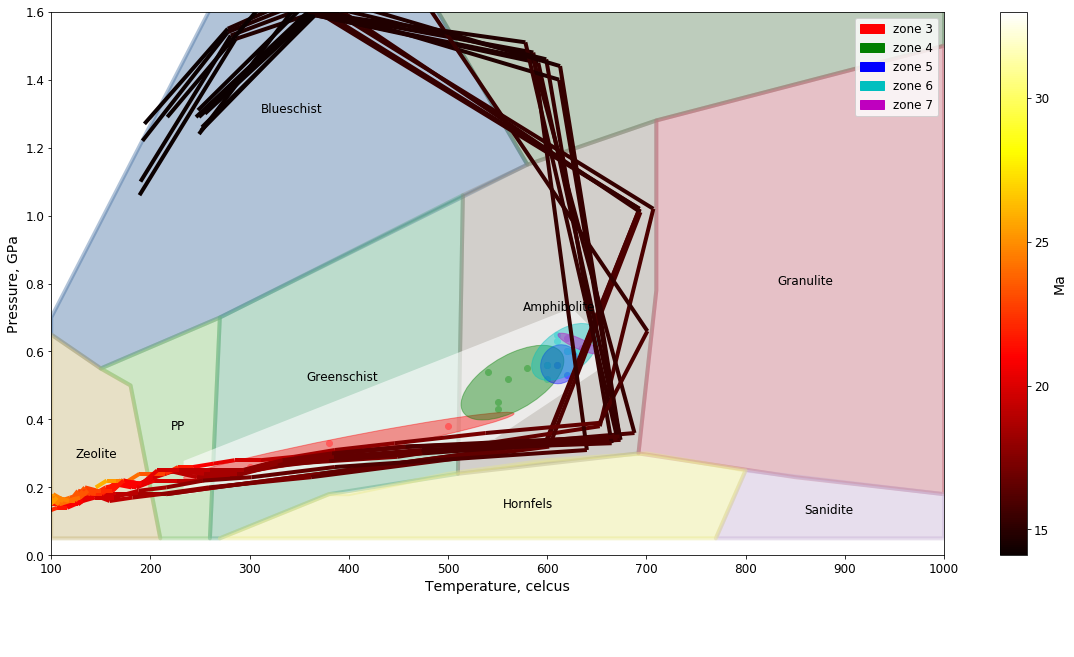

In [26]:
pol, col,cents = create_collections(data)
_dl,_dt = filter_by_cluster([2,3,4])
config = {
    'polygons': pol,
    'colors'  : col,
    'centers' : cents,
    'names'   : data.name,
    'exp_temp': experiments.temp,
    'exp_pres': experiments.pres,
    'exp_color':experiments.color,
    'exp_zone': experiments.zone,
    'res_lines': _dl,
    'res_time' : _dt,
    'focus_area'    : focus_area
}

focus_area = plot_polygons(config)

In [27]:
lines_with_clusters = df2.reset_index()

In [28]:
def create_depth_paths(group):
    _x = group['x']
    _y = group['y']
    return (_x,_y)

In [29]:
def draw_voacc(_data, titles, dots, xlabel, ylabel, zoom, color_map, nrows=2, ncols=2, suptitle = 'test title'):
    plt.close('all')
    cmap = colors.ListedColormap(color_map)
    #plt.figure(figsize=(20,10))
    bounds=list(range(0,39))
    norm = colors.BoundaryNorm(bounds, cmap.N)

    xlim = zoom['xlim']
    ylim = zoom['ylim']

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex='col', sharey='row', figsize = (20,20))
    p_num = 0
    #fig.set_size_inches(11.69,8.27)
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            col.imshow(_data[p_num], norm=norm, cmap=cmap, aspect=4)
            circles = []
            x,y = dots[p_num]
            for a,b in zip(x, y):
                circles.append(patches.Ellipse((a/1000, b/1000),width=4, height=1))
            pc = PatchCollection(circles, facecolor = 'w')
            col.add_collection(pc)
            col.set_xlim(xlim)
            col.set_ylim(ylim)
            col.set_title(f'{titles[p_num]} ma')
            if j == 0:
                col.set_ylabel(xlabel)
            if i == nrows - 1:
                col.set_xlabel(ylabel)
            col.invert_yaxis()
            p_num = p_num + 1
            #col.plot(x, y)
    fig.tight_layout()
    fig.suptitle(suptitle, y = 1.05)
    
    #fig.legend(lines, labels, loc = (0.5, 0), ncol=5 )
    #fig.savefig("foo.emf", papertype = 'a4', orientation = 'portrait', format = 'emf')

In [30]:
def read_voacc(fld):
    _data = []
    _time = []
    folder, _ ,files = list(walk(fld))[0]
    files = np.array(sorted(files))
    files = [f for f in files if "voac" in f]
    print(files)
    for file in files:
        fp = open(folder + file)
        for i, line in enumerate(fp):
            if i == 0: 
                _time.append(round(float(list(filter(lambda c: c!='' and c !='\n', line.split(' ')))[0][:4])*10, 3))
            if i == 1: 
                splitted = line.split(' ')
                nx, ny = list(filter(lambda c: c!='' and c !='\n', splitted))
            if i == 2:
                voacc = np.array(list(map(lambda d: int(d), filter(lambda c: c!='' and c !='\n', line.split(' ')))))
                _data.append(voacc)
        fp.close()
    _data = np.array(_data)
    return (_time, _data)

In [31]:
def parse_voacc(Data_vec):
    color_grid = np.zeros(shape=(401,4001))
    num       = 0;
    ind_vec1 = ind_vec2 = 0
    ind       = 0;
    while num<len(Data_vec):
        value = Data_vec[num]
        if value==-2:
            #Compressed: the next ?? indices are given the color material
            num_colors  =   Data_vec[num+1]
            material    =   Data_vec[num+2]
            ind_vec1 = ind;
            ind_vec2 = ind + num_colors - 1;
            ind         =   ind + num_colors
            num         =   num + 3
        else:
            if value==-1:
                material    =   0
            else:
                material    =   value
            ind_vec2 = ind
            ind_vec1 = ind
            ind = ind + 1
            num = num + 1
        for n in range(ind_vec1, ind_vec2+1):
            jj = int(n / 401)
            ii = int(n % 401)
            color_grid[ii][jj] = material
    return color_grid

In [ ]:
cluster_id = '2,3,4'
lines_from_second_cluster = lines_with_clusters[(lines_with_clusters['cluster'] == 2) | (lines_with_clusters['cluster'] == 3) | (lines_with_clusters['cluster'] == 4)]
#lines_from_second_cluster = lines_with_clusters[lines_with_clusters['cluster'] == cluster_id]

In [49]:
df_cluster_two = df[df['id'].isin(lines_from_second_cluster['id'])]
min_depth_markers_id = df_cluster_two[(df_cluster_two['y'] < 10000) & (df_cluster_two['x'] > 0)].id.unique()
#in_depth_markers_id = df[(df['y'] < 10000) & (df['x'] > 0)].id.unique()

In [50]:
x_y = df[df['id'].isin(min_depth_markers_id)].groupby('id').apply(create_depth_paths)
times = df[df['id'].isin(min_depth_markers_id)].groupby('id').apply(create_time)

In [51]:
by_time = df[df['id'].isin(min_depth_markers_id)].groupby('ma').apply(create_depth_paths)

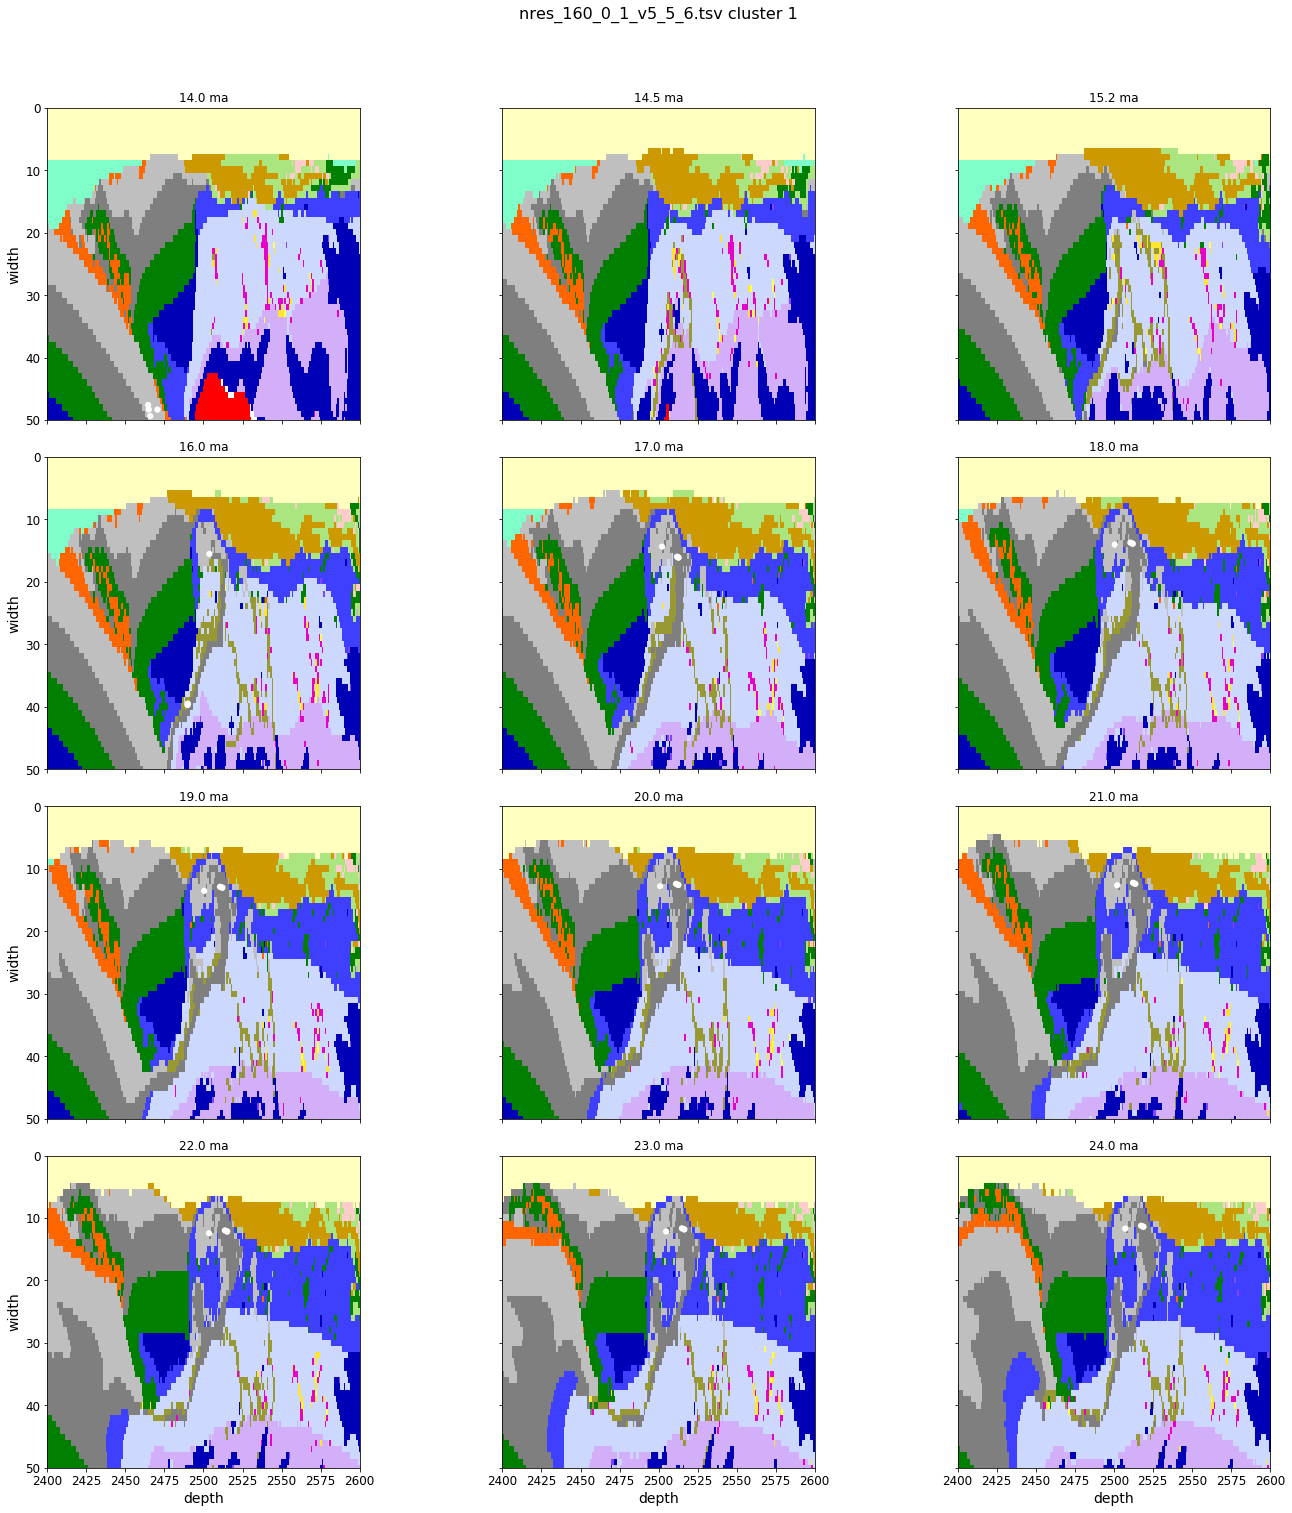

In [52]:
draw_voacc(res, time, by_time.values, 'width', 'depth', {'xlim': (2400, 2600), 'ylim': (0, 50)}, C_map, ncols = 3, nrows = 4, suptitle = f'{model_name} cluster {cluster_id}')

In [53]:
by_lines = df[df['id'].isin(min_depth_markers_id)].groupby('id').apply(create_depth_paths)

In [ ]:
import matplotlib.ticker as mtick
for x,y in by_lines.values:
    plt.plot(list(map(lambda _x: _x/1000, x)),list(map(lambda _y: _y / 1000, y)))
plt.gca().invert_yaxis()
plt.xlabel('depth km')
plt.ylabel('width km')
plt.gca().set_xlim(2400,2600)
_ = plt.title(f'{model_name} cluster {cluster_id}')

In [40]:
len(by_lines.values)

1646